# Climate extremes insights from $E^3CI$

![alt text](data/logo_e3c_int.svg "European Extreme Events Climate Index")

The *European Extreme Events Climate Index* ($E^3CI$) is a tool for the monitoring of the occurrence and magnitude of extreme weather events.
It is composed by a set of components related to different perils evaluated at a monthly scale and a composite index resuming the impact of components as a whole.

The E3CI is a project funded by IFAB (https://www.ifabfoundation.org/), the International Foundation Big Data and Artificial Intelligence for Human Development, and implemented by Leithà (https://leitha.eu/), the insurtech company of the Unipol Group, and the Euro-Mediterranean Center on Climate Change (CMCC) (https://www.cmcc.it/).

The computation is based on ERA5 data produced by ECMWF and distributed by the Copernicus Climate Change Service (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview).

Each component of $E^3CI$  has been designed in order to asses the potential occurence of an extreme event based on its frequency anomaly with respect to a historical baseline referred to the period 1981-2010.

Here follows a brief description of $E^3CI$ components:

1. **Heat stress**: this component measures the anomaly of the number of days in the month with maximum hourly temperature above time-dependent thresholds with respect to the expected number of exceedings based on historical baseline.

2. **Cold stress**: this component measures the anomaly of the number of days in the month with minimum hourly temperature below time-dependent thresholds with respect to the expected number of exceedings based on historical baseline.

3. **Extreme precipitation**: this component measures the anomaly of the monthly precipitation fraction due to heavy rain with respect to that estimated based on the historical baseline for that month of the year. 

4. **Drought**: the drought component is given by the Standardized Precipitation Index (SPI)[2].

5. **Extreme wind**: this component measures the anomaly of the *Local Loss Index*[1] with respect to that estimated based on the historical baseline for that month of the year. 

A detailed description of $E^3CI$ can be found here: https://www.ifabfoundation.org/e3ci/.

#### References
* [1]: *Donat, Markus G., et al. "Benefits and limitations of regional multi-model ensembles for storm loss estimations." Climate Research 44.2-3 (2010): 211-225.*
* [2]: *McKee, Thomas B., Nolan J. Doesken, and John Kleist. "The relationship of drought frequency and duration to time scales." Proceedings of the 8th Conference on Applied Climatology. Vol. 17. No. 22. 1993.*

## Table of contents

* [1. Data reading and preparation](#section_1)
* [2. Exploratory data analysis](#section_2)
    * [2.1 Decades trends](#section_21)
    * [2.2 Spatial trends](#section_22)
    * [2.3 Seasonality checks](#section_23)
    * [2.4 Known events](#section_24)
* [3. Clustering](#section_3)
    * [3.1. Time series clustering](#section_31)
    * [3.2. Clustering on average components](#section_32)

In [ ]:
!pip install -r requirements.txt

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

<a id="section_1"></a>
## 1. Data reading and preparation

In this tutorial we will use an $E^3CI$ dataset aggregated at country level.

In [3]:
data = pd.read_excel('./data/e3ci_dataset_workshop.xlsx', index_col=0, header=[0, 1])

In [4]:
countries = gpd.read_file('./data/europe.geojson')

It will be useful to consider whether each component value exceeded a warning threshold here considered equal to 1:

In [5]:
threshold = 1
data_gt1 = data.apply(lambda x: x > threshold)

<a id="section_2"></a>
## 2. Exploratory data analysis

In [6]:
components = ['Heat stress', 'Cold stress', 'Drought', 'Extreme precipitation', 'Extreme wind']

In order to perform some exploration on data let's select a specific country. Feel free to change it in order to explore $E^3CI$ on your country of interest.

In [7]:
country_name = 'Italy'

In [8]:
data_country = data[country_name]
data_country_gt1 = data_gt1[country_name]

<a id="section_21"></a>
### 2.1 Decades trends

Since $E^3CI$ accounts for a historical baseline referred to the period 1981-2010, we expect to observe average values close to zero on the same period, while larger values are expected corresponding to recent years due to climate change effets:

In [9]:
data_country.loc[slice(None, datetime(2011, 1, 1))].mean()

Type
Cold stress             -0.000525
Drought                 -0.002776
E3CI                    -0.000994
Extreme precipitation   -0.000536
Extreme wind            -0.001316
Heat stress              0.000184
dtype: float64

In [10]:
data_country.loc[slice(datetime(2011, 1, 1), None)].mean()

Type
Cold stress             -0.433219
Drought                 -0.076875
E3CI                     0.130437
Extreme precipitation    0.170126
Extreme wind             0.189462
Heat stress              0.802690
dtype: float64

Indeed, some magnitude of increasing of extremes is shown by **Extreme precipitation**, **Extreme wind**, **Heat stress** components and the composite **E3CI** index.

Now, let's aggregate by decade and plot the average components values and exceedings counts

In [11]:
decade_idxs = pd.cut(data_country.index.year, [1980, 1990, 2000, 2010, 2020])

In [12]:
decade_gt1 = data_country_gt1.groupby(decade_idxs).sum()

#### Number of exceedings

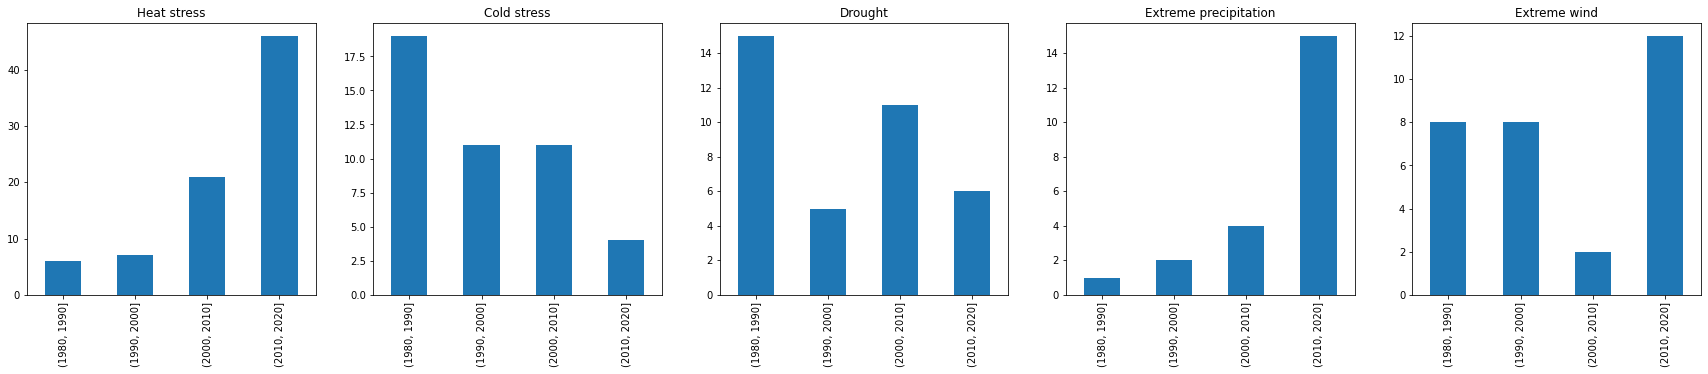

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for component, ax in zip(components, axes):
    decade_gt1[component].plot.bar(ax=ax)
    ax.set_title(component)

The following analyses will consider only data outside the baseline period.

In [14]:
data = data.loc[slice(datetime(2011, 1, 1), None)]
data_country = data_country.loc[slice(datetime(2011, 1, 1), None)]

data_gt1 = data_gt1.loc[slice(datetime(2011, 1, 1), None)]
data_country_gt1 = data_country_gt1.loc[slice(datetime(2011, 1, 1), None)]

<a id="section_22"></a>
### 2.2 Spatial trends

In order to visualize spatial patterns we plot maps of country average values.

In [15]:
country_agg_gt1 = data_gt1.sum()

#### Number of exceedings

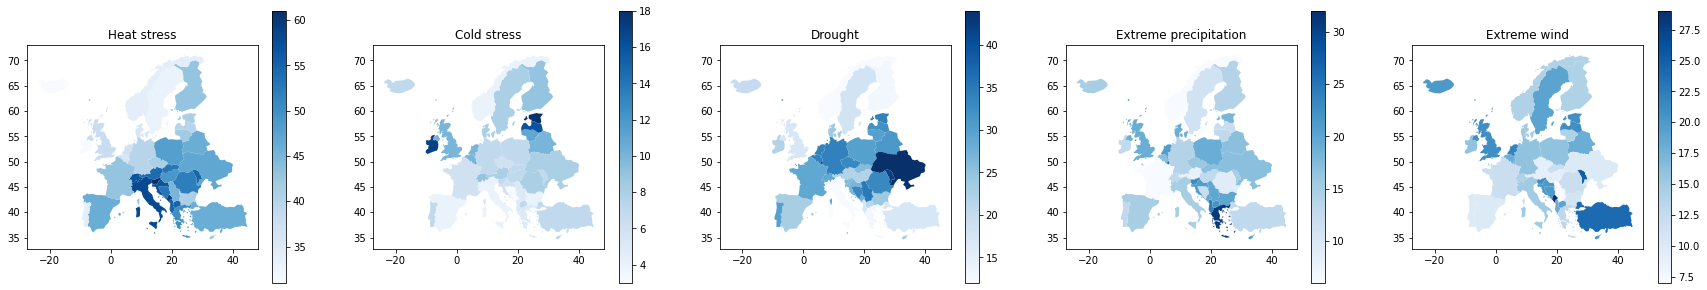

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for component, ax in zip(components, axes):
    country_data = countries.join(country_agg_gt1.loc[:, component].rename(component), on='NAME_ENGL', how='inner')
    country_data.plot(column=component, ax=ax, legend=True, cmap='Blues')
    ax.set_title(component)

<a id="section_23"></a>
### 2.3 Seasonality checks

In [17]:
seasons = {1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM', 6: 'JJA', 
            7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON', 12: 'DJF'}
data_gt1['Season'] = data_gt1.index.month.map(seasons)

In [18]:
season_agg_gt1 = data_gt1.groupby('Season').sum().reindex(['DJF','MAM','JJA','SON'])

#### Number of exceedings

In [19]:
country = 'Germany'

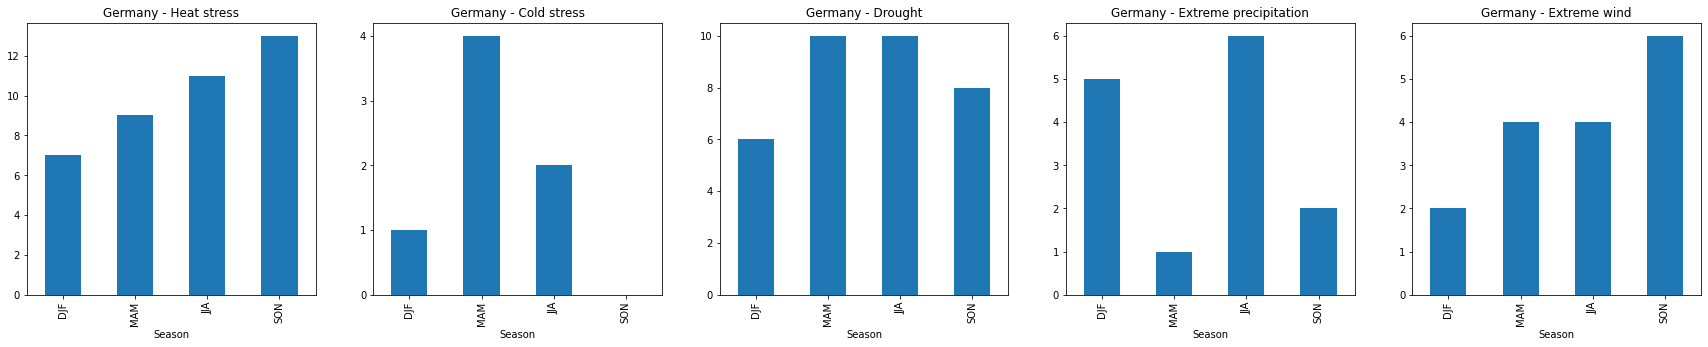

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for component, ax in zip(components, axes):
    season_agg_gt1[country][component].plot.bar(ax=ax)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f'{country} - {component}')

<a id="section_24"></a>
### 2.4 Known events

The [European State of the Climate 2021](https://climate.copernicus.eu/sites/default/files/2022-07/ESOTCsummary2021_static.pdf) highlights following climate extremes registered during 2021:

Peril | Countries | Months
---|---|---
Heat stress|Italy, Greece, Spain, Turkey| 6, 7, 8
Extreme precipitation|Belgium, Germany, Luxembourg, Netherlands|7

In [21]:
data_gt1[['Italy', 'Spain', 'Greece', 'Turkey']].xs('Heat stress', axis=1, level=1).loc[
    [datetime(2021, 6, 1), datetime(2021, 7, 1), datetime(2021, 8, 1)]
]

Country,Italy,Spain,Greece,Turkey
Month,,,,
2021-06-01,True,False,True,False
2021-07-01,False,False,True,True
2021-08-01,True,False,True,False


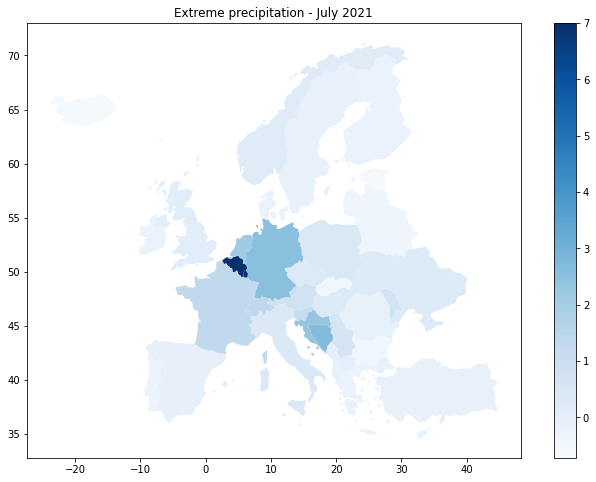

In [22]:
component = 'Extreme precipitation'
event_data = data.xs(component, axis=1, level=1).loc[datetime(2021, 7, 1)].rename(component)

fig, ax = plt.subplots(figsize=(12,8))
country_data = countries.join(event_data, on='NAME_ENGL', how='inner')
country_data.plot(column=component, ax=ax, legend=True, cmap='Blues',vmax=7)
ax.set_title(f'{component} - July 2021')
fig.show()

In [23]:
event_data[['Belgium', 'Germany', 'Luxembourg', 'Netherlands']]

Country
Belgium         7.201934
Germany         2.551651
Luxembourg     13.211065
Netherlands     2.147316
Name: Extreme precipitation, dtype: float64

<a id="section_3"></a>
## 3. Clustering

<a id="section_31"></a>
### 3.1 Time series clustering

A clustering of time series allows to identify groups of countries with similar time patterns of extreme occurrences.

Here, we will apply the `TimeSeriesKMeans` module provided by the [tslearn](https://tslearn.readthedocs.io/en/stable/index.html) library in order to perform a K-means on the **Heat stress** component countries time series.

In order to select an appropriate number of clusters we adopt the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

In [24]:
time_series_data = data.xs('Heat stress', axis=1, level=1, drop_level=False).T

In [25]:
location_list = time_series_data.index.get_level_values('Country')

In [26]:
data_array = np.array(time_series_data.values)

In [27]:
inertia = []

K = range(1,50)
for k in tqdm(K):
    model = TimeSeriesKMeans(n_clusters=k)
    km = model.fit(data_array)
    inertia.append(km.inertia_)

100%|██████████| 49/49 [00:13<00:00,  3.51it/s]


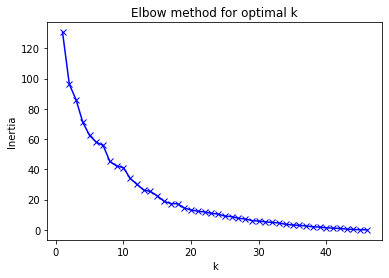

In [28]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal k')
plt.show()

In [29]:
n_clusters = 17

In [30]:
data_array = np.array(time_series_data.values)

model = TimeSeriesKMeans(n_clusters=n_clusters)
model.fit(data_array)

TimeSeriesKMeans(n_clusters=17)

In [31]:
y = model.predict(data_array)

/opt/conda/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 46 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [32]:
country_cluster = dict(zip(location_list,y))
europe = countries[countries['NAME_ENGL'].isin(location_list)]
europe['cluster'] = europe.apply(lambda row: country_cluster[row['NAME_ENGL']], axis=1)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
europe.explore(column='cluster', 
               legend=True, 
               categorical=True, 
               popup=True,
               cmap="Paired",
               style_kwds=dict(color="black"))

<a id="section_32"></a>
### 3.2 Clustering on average components

We want to find clusters of Countries affected by extremes with similar proportions of impacts related to different components.

In [34]:
data_agg_pivot = data.stack().mean(level=1, skipna=True).T
data_agg_pivot = data_agg_pivot.div(data_agg_pivot.sum(axis=1), axis=0)

In [35]:
data_agg_pivot.drop('E3CI', axis=1, inplace=True)

In [36]:
data_array = np.array(data_agg_pivot.values)
inertia = []

K = range(1,40)
for k in tqdm(K):
    model = KMeans(n_clusters=k)
    km = model.fit(data_agg_pivot)
    inertia.append(km.inertia_)

100%|██████████| 39/39 [00:13<00:00,  2.93it/s]


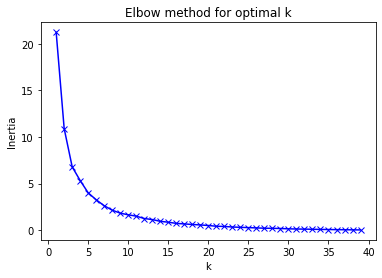

In [37]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal k')
plt.show()

In [38]:
n_clusters = 6

In [39]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_agg_pivot)

In [40]:
data_agg_pivot['cluster'] = kmeans.labels_

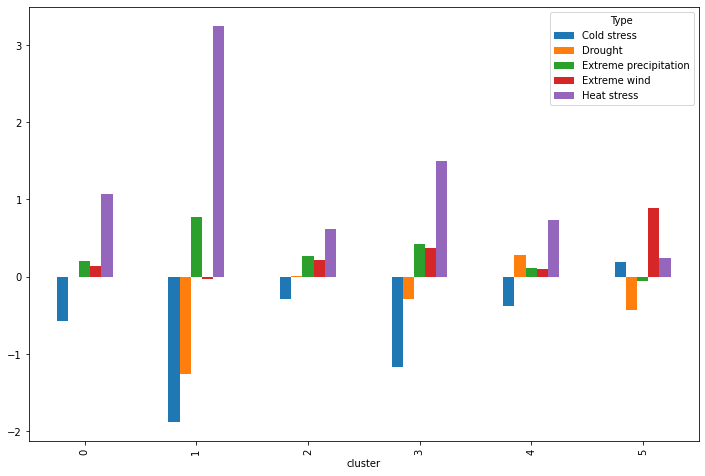

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
means = data_agg_pivot.groupby('cluster').mean()
means.plot.bar(ax=ax)
fig.show()

In [42]:
clustering = countries.join(data_agg_pivot, on='NAME_ENGL', how='inner')
clustering.explore(column='cluster', cmap="Paired", categorical=True)